In [1]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statistics import median

import matplotlib.pyplot as plt
import seaborn as sns

## Imported Data

In [2]:
# Load csv data as a dataframe
df = pd.read_csv('field_reads.csv')

# Create dataframes for each set of interest
df_zero = df.iloc[:, :2]

df_quad = pd.read_csv('quad_reads_raw.csv')

df_zeeman = df.iloc[:,2:-2]

# Manually Collected Data (Absorbtion Testing)
t_vals = [396.65, 390, 380, 370, 360, 350, 340, 330, 320, 310]
n_vals = [(10**(7.193 - (4040 / t))) * (101325 / 760) / (1.38E-23 * t) for t in t_vals]
V_det = [0.06, 0.07, 0.08, 0.1075, 0.17, 0.25, 0.36, 0.46, 0.54, 0.6]

## Temperature vs Absorbtion Distributions

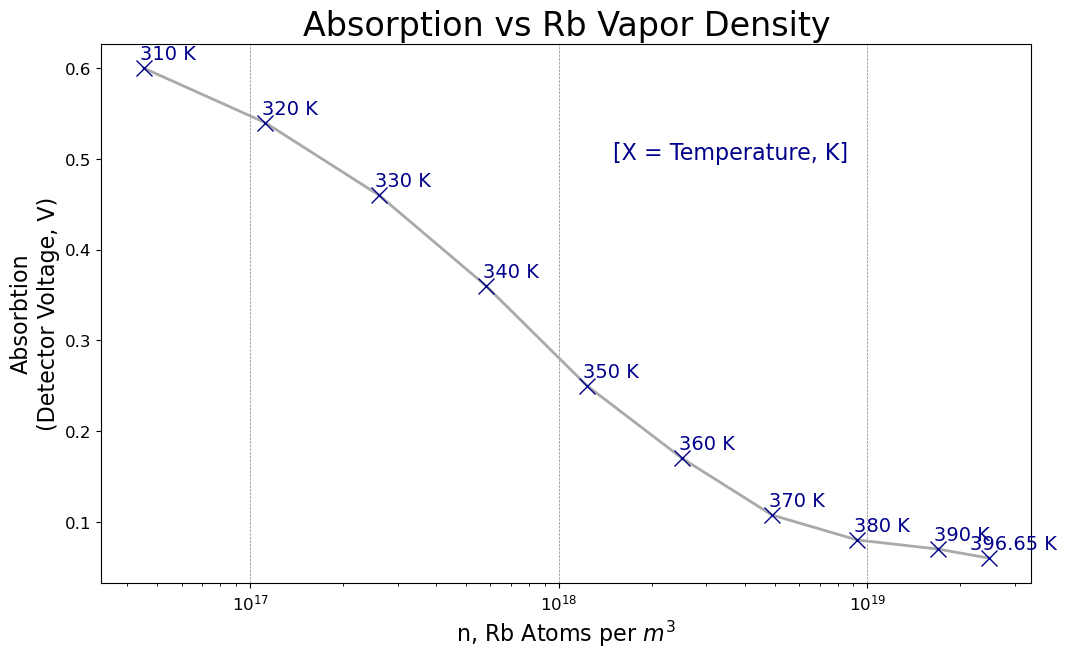

In [3]:
plt.rcParams.update({'font.size': 12})  # Default font size for all text
plt.rcParams.update({'axes.titlesize': 24})  # Font size of the titles
plt.rcParams.update({'axes.labelsize': 16})  # Font size of the x and y labels

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize = (12,7))

# Plotting on the primary axis with a log scale, black 'x' markers, and dark grey lines
ax1.plot(n_vals, V_det, 'x-', color='darkgrey', markersize=12, linewidth=2, mec='darkblue')
ax1.set_xscale('log')  # Set the log scale for the x-axis

# Label each data point with the corresponding temperature
for (n, v, t) in zip(n_vals, V_det, t_vals):
    ax1.text(n*1.2, v+.005, f'{t} K', fontsize=14, color = 'darkblue',
             verticalalignment='bottom', horizontalalignment='center')

# Adding vertical gridlines for the x-axis only
ax1.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5, color='grey')

ax1.text(1.5*10e17, 0.5,'[X = Temperature, K]', fontsize=16, color='darkblue')

# Setting the axis labels
ax1.set_xlabel('n, Rb Atoms per $m^3$')
ax1.set_ylabel('Absorbtion\n(Detector Voltage, V)')

plt.title('Absorption vs Rb Vapor Density')

plt.show()

# Collected Data

In [4]:
# Data object to hold all results
results = []

## Zero field transition

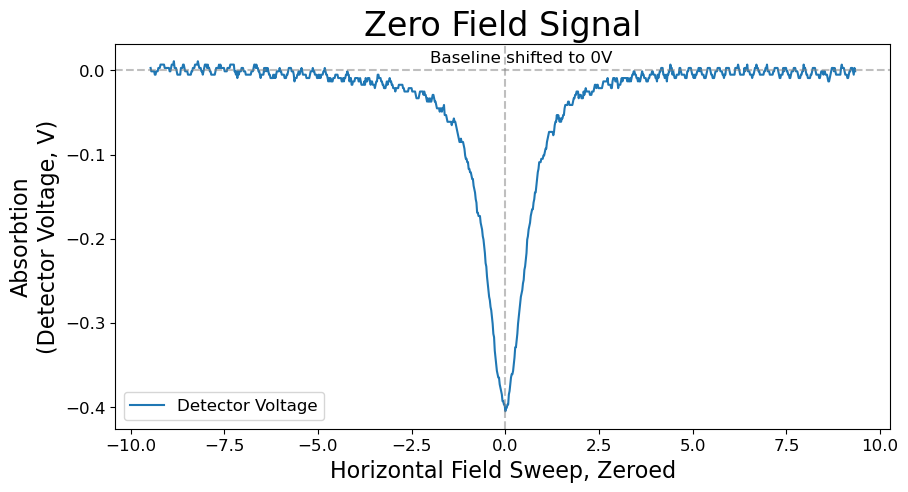

In [5]:
# Extract the original sweep data for the column to be used as the new x-axis
original_x_values = df_zero[df_zero.columns[0]].values

# Generate new x-values with 1000 points spaced evenly between the min and max of the original x-values
new_x_values = np.linspace(original_x_values.min(), original_x_values.max(), 1000)

# Pull detector reading data, then negate to make minimum maximum (to work with find_peaks function)
data_zero = df_zero[df_zero.columns[1]].values
inverted_data_zero = -np.array(data_zero)

# Find peaks in the inverted data (thus, minimums since it is inverted;
# Adjust parameters as needed; Note: '_' is a necessary empty return value holder
zero_peak, _ = find_peaks(inverted_data_zero, distance = 50, prominence=0.1)  # Adjust prominence and distance using graph above

#! - shift these to the right to rezero.  Hey its the xval at minimum!
zero_x_vals = [t - float(new_x_values[zero_peak]) for t in new_x_values]

# Get baseline voltage from the average of the first and last 5 measurements
baseline = round((sum(data_zero[:5]) + sum(data_zero[-5:]))/10,3)

# Shift the entire graph down by baseline for cleaner calculation of voltage drop at detector
data_zero = data_zero - baseline

# Get list of minima values
minimas = data_zero[zero_peak]

# Plotting to check accuracy (can comment out after peaks confirmed)
plt.figure(figsize=(10, 5))
plt.plot(zero_x_vals, data_zero, label='Detector Voltage')
#plt.plot(zero_x_vals[zero_peak], minimas, "x", label=f'Identified Minima = {[round(x,3) for x in minimas]}V')


plt.xlabel('Horizontal Field Sweep, Zeroed')
plt.ylabel('Absorbtion\n(Detector Voltage, V)')
plt.title('Zero Field Signal')
plt.legend()

# Adding in the baselines
# Horiz
plt.axhline(0, color = 'grey', linestyle = 'dashed', alpha = .5)
plt.text(-2,.01,f'Baseline shifted to 0V')
# Vertical
plt.axvline(0, color = 'grey', linestyle = 'dashed', alpha = .5)

# Add in Information


plt.show()

# print(f"Sweep Voltage at Minimas = {new_x_values[zero_peak]}V")
# print(f"Detector Voltage at Minimas = {df_zero.iloc[zero_peak,1].values-baseline}V")

for i in range(len(minimas)):
        results.append(('Zero Field',
                new_x_values[zero_peak][i]))

## Zeemans:

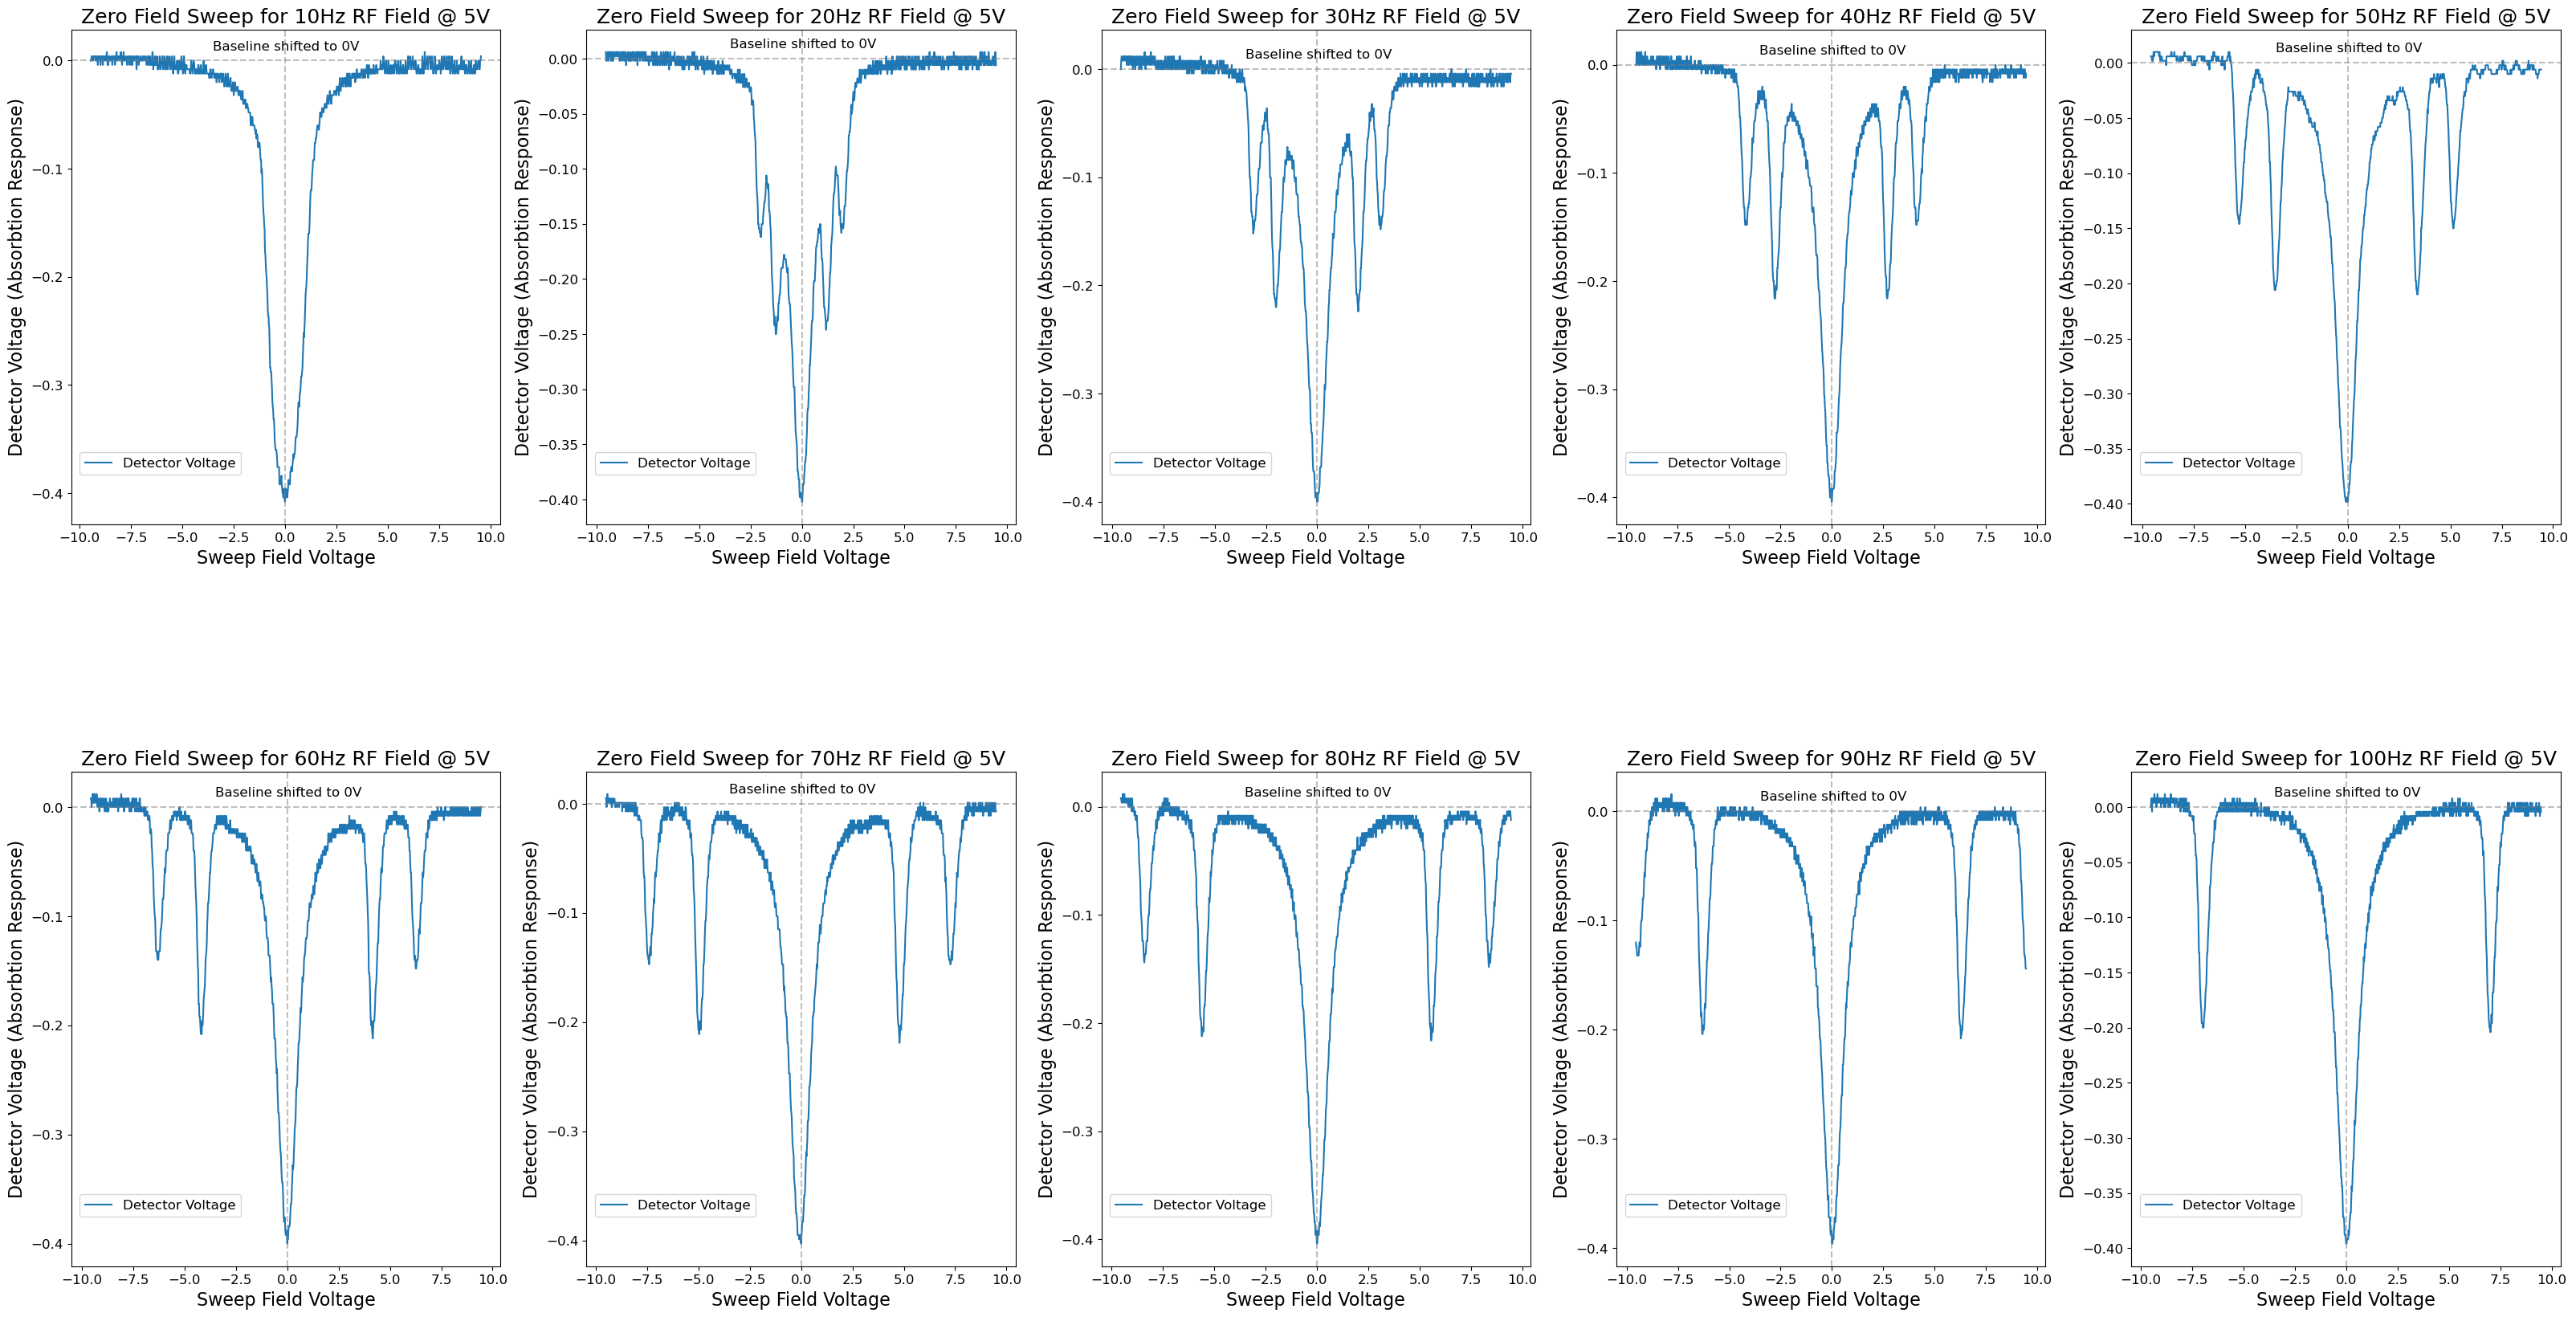

In [6]:
# Setup the subplot grid
fig, axs = plt.subplots(2, 5, figsize=(40, 20))  # Adjust figsize to fit your screen/desired output size
axs = axs.flatten()  # Flatten the array of axes to easily access them in a loop

plt.rcParams.update({'font.size': 12})  # Default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Font size of the titles
plt.rcParams.update({'axes.labelsize': 14})  # Font size of the x and y labels

# Looping through pairs of columns
for i in range(0, len(df_zeeman.columns), 2):
    ax = axs[i // 2]

    # Extract the original data for the column to be used as the new x-axis
    original_x_values = df_zeeman[df_zeeman.columns[i]].values
    # Generate new x-values with 1000 points spaced evenly between the min and max of the original x-values
    new_x_values = np.linspace(original_x_values.min(), original_x_values.max(), 1000)

    # Pull the y-values from the detector response
    y_values = df_zeeman[df_zeeman.columns[i + 1]].values
    # Invert the data
    inverted_data_zeeman = -np.array(y_values)
    
    # Find peaks in the inverted data, adjust parameters as needed; '_' is a necessary empty return value holder
    peaks, _ = find_peaks(inverted_data_zeeman, distance = 20, prominence=0.05)  # Adjust prominence and distance using graph above

    #! - shift these to the right to rezero.  Hey its the xval at minimum!
    zero_x_vals = [t - float(new_x_values[median(peaks)]) for t in new_x_values]
    
    # Get baseline voltage from the first and last 5 measurements
    # Note that 90Hz has to be netered manuially due to boundary condition issues
    if df_zeeman.columns[i] == '90-1':
        baseline = .1
    else:
        baseline = round((sum(y_values[:5]) + sum(y_values[-5:]))/10,3) 
        
    y_values = y_values - baseline
    
    minimas = y_values[peaks]
                    
    # Plot
    ax.plot(zero_x_vals, y_values, label='Detector Voltage')
    #ax.plot(new_x_values[peaks],minimas,"x", label=f'Identified Minima = {[round(x,3) for x in minimas]}V')
    ax.set_xlabel('Sweep Field Voltage')  
    ax.set_ylabel('Detector Voltage (Absorbtion Response)')  
    title = df_zeeman.columns[i].split('-')[0]
    
    ax.set_title(f'Zero Field Sweep for {title}Hz RF Field @ 5V')
    # Vertical
    ax.axvline(0, color = 'grey', linestyle = 'dashed', alpha = .5)

    ax.axhline(0, color = 'grey', linestyle = 'dashed', alpha=.5)
    ax.text(-3.5,.01,f'Baseline shifted to 0V')
    ax.legend(loc = (.02,.1))
    
    for i in range(len(minimas)):
        results.append((int(title),
                        new_x_values[peaks][i]))
        
   
fig.subplots_adjust(hspace=.5)  # Adjust this value to increase spacing between rows

plt.show()  # Display the plot grid

### Plotting of gF and B

In [7]:
# Ensure even numbers of Hz
data = [results[1]]*2 + results[1:-6]

data = [d for d in data if d[1] >= 0]

In [8]:
k_1 = []
k_2 = []
k_3 = []

counter = 0
for row in data:
    if counter == 0:
        k_1.append((row[1],row[0]))
    elif counter == 1:
        k_2.append((row[1],row[0]))
    else:
        k_3.append((row[1],row[0]))
        counter = 0
        continue
    counter += 1
    
d = [k_2] + [k_3]

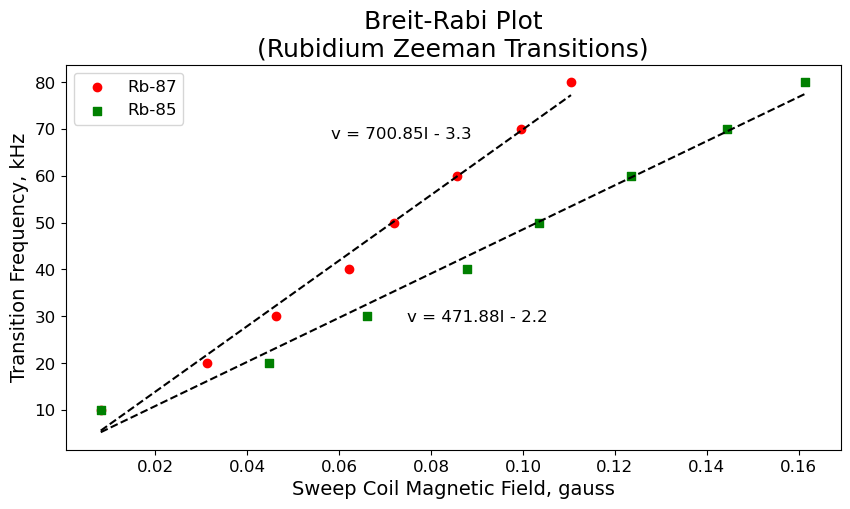

In [9]:
# Initialize plot
fig, ax = plt.subplots(figsize = (10,5))

# Colors for different datasets
colors = ['red', 'green']
markers = ['o', 's']
isos = [87,85]
text_coord = [(140,210),(150,80)]
yint = [3.3,2.2]

# To store regression lines data
regression_lines = []

# Plotting each set of data points and calculating regression lines
for index, sublist in enumerate(d):
    x = np.array([(point[0]/10 * 8.991e-3 * 11/.1639 * .3) for point in sublist]).reshape(-1, 1)
    y = np.array([point[1] for point in sublist])  # Y values

    # Scatter plot of points
    ax.scatter(x, y, color=colors[index], label=f'Rb-{isos[index]}', marker=markers[index])

    # Polynomial Features Transformation
    poly = PolynomialFeatures(degree=1)
    x_poly = poly.fit_transform(x)
    
    # Polynomial Regression
    model = LinearRegression()
    model.fit(x_poly, y)
    line_x = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    line_y = model.predict(poly.transform(line_x))
    # Extracting the slope of the linear component of the polynomial regression

    # Annotate the slope near the start of each curve
    ax.annotate(f'v = {model.coef_[1]:.2f}I - {yint[index]}', (x[1], line_y[0]), textcoords="offset points", xytext=text_coord[index], ha='center')

    # Plot the regression curve
    ax.plot(line_x, line_y, 'k--')
    
# Plot regression lines
for line_x, line_y, slope in regression_lines:
    ax.plot(line_x, line_y, 'k--')

# Add title and labels
ax.set_title('Breit-Rabi Plot\n(Rubidium Zeeman Transitions)')
ax.set_xlabel('Sweep Coil Magnetic Field, gauss')
ax.set_ylabel('Transition Frequency, kHz')

# Show legend
ax.legend()

# Show plot
plt.show()

In [10]:
# g_j = total angular momentum g-factor, also g_f
# g_i

## Quadratic Zeeman

In [11]:
df_quad

,Q10-1,Q10-2,Q20-1,Q20-2,Q30-1,Q30-2,Q40-1,Q40-2,Q50-1,Q50-2,Q60-1,Q60-2
0,-7.2,0.040,-8.4,0.168,-7.0,0.096,-9.4,-0.064,-7.4,0.000,-7.8,0.016
1,-7.2,0.040,-8.4,0.168,-7.0,0.096,-9.4,-0.064,-7.4,0.000,-8.0,0.016
2,-7.4,0.048,-8.4,0.160,-6.8,0.096,-9.2,-0.072,-7.4,0.000,-7.8,0.016
3,-7.2,0.048,-8.4,0.168,-7.0,0.104,-9.2,-0.064,-7.4,0.000,-7.6,0.008
4,-7.4,0.040,-8.4,0.168,-7.0,0.096,-9.2,-0.056,-7.4,0.000,-7.8,0.008
...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.8,0.008,6.6,0.072,7.6,0.048,5.6,-0.184,7.6,-0.080,7.0,-0.040
996,7.6,0.008,6.6,0.080,8.0,0.048,5.8,-0.176,7.6,-0.072,7.2,-0.048
997,7.6,0.000,6.6,0.080,8.0,0.048,5.8,-0.176,7.6,-0.072,7.2,-0.048
998,7.6,0.000,6.6,0.088,7.8,0.048,5.6,-0.176,7.6,-0.080,7.4,-0.048


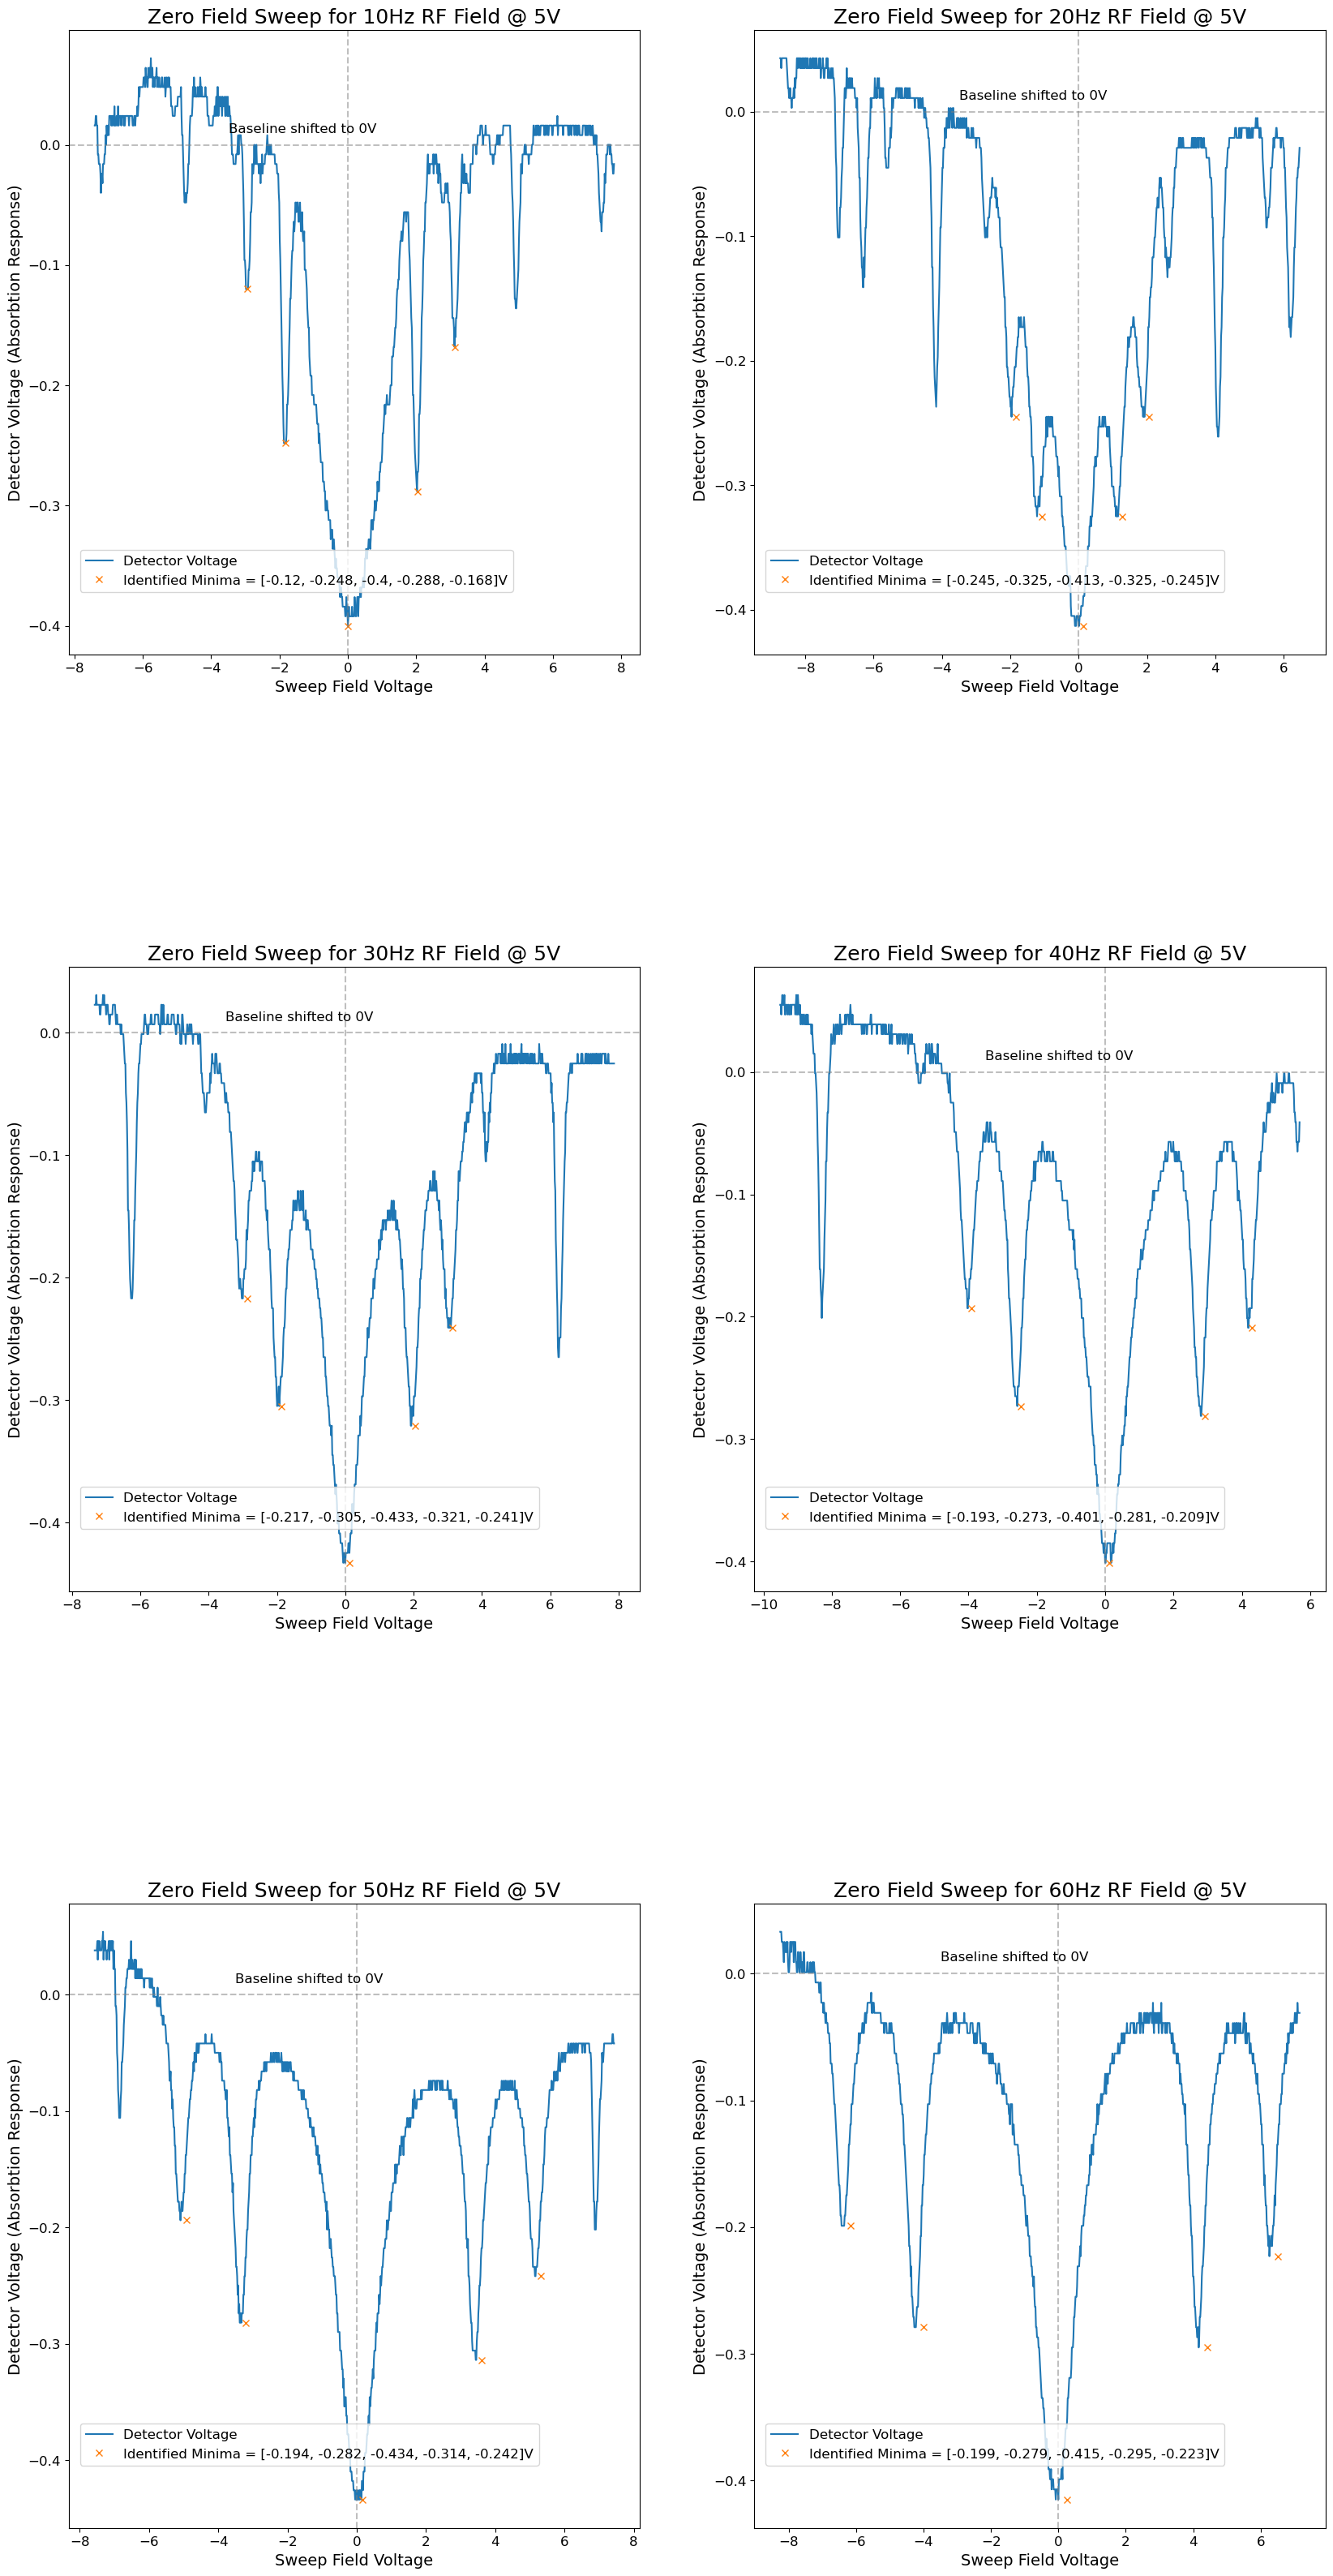

In [12]:
df_quad_results = []

# Setup the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(20, 40))  # Adjust figsize to fit your screen/desired output size
axs = axs.flatten()  # Flatten the array of axes to easily access them in a loop

plt.rcParams.update({'font.size': 12})  # Default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Font size of the titles
plt.rcParams.update({'axes.labelsize': 14})  # Font size of the x and y labels

# Looping through pairs of columns
for i in range(0, len(df_quad.columns), 2):
    ax = axs[i // 2]

    # Extract the original data for the column to be used as the new x-axis
    original_x_values = df_quad[df_quad.columns[i]].values
    # Generate new x-values with 1000 points spaced evenly between the min and max of the original x-values
    new_x_values = np.linspace(original_x_values.min(), original_x_values.max(), 1000)
    
    # Pull the y-values from the detector response
    y_values = df_quad[df_quad.columns[i + 1]].values
    # Invert the data
    inverted_data_quad = -np.array(y_values)
    
    # Find peaks in the inverted data, adjust parameters as needed; '_' is a necessary empty return value holder
    peaks, _ = find_peaks(inverted_data_quad, distance = 20, prominence=0.05)  # Adjust prominence and distance using graph above

    #!#!#!
    # Manual
    if i == 0:
        peaks = peaks[2:-2]
    elif i == 2:
        peaks = peaks[4:9]
    elif i == 4:
        peaks = peaks[1:6]
    elif i == 6:
        peaks = peaks[1:]
    elif i == 8:
        peaks = peaks[1:-1]

    
    zero_x_vals = [t - float(new_x_values[median(peaks)]) for t in new_x_values]
    # Get baseline voltage from the first and last 5 measurements
    # Note that 90Hz has to be netered manuially due to boundary condition issues
    baseline = round((sum(y_values[:5]) + sum(y_values[-5:]))/10,3) 
        
    y_values = y_values - baseline
    
    minimas = y_values[peaks]
                    
    # Plot
    ax.plot(zero_x_vals, y_values, label='Detector Voltage')
    ax.plot(new_x_values[peaks],minimas,"x", label=f'Identified Minima = {[round(x,3) for x in minimas]}V')
    ax.set_xlabel('Sweep Field Voltage')  
    ax.set_ylabel('Detector Voltage (Absorbtion Response)')  
    title = df_quad.columns[i][1:].split('-')[0]
    
    ax.set_title(f'Zero Field Sweep for {title}Hz RF Field @ 5V')
    # Vertical
    ax.axvline(0, color = 'grey', linestyle = 'dashed', alpha = .5)

    ax.axhline(0, color = 'grey', linestyle = 'dashed', alpha=.5)
    ax.text(-3.5,.01,f'Baseline shifted to 0V')
    ax.legend(loc = (.02,.1))
    
    for i in range(len(minimas)):
        df_quad_results.append((int(title),
                                new_x_values[peaks][i]))
            
fig.subplots_adjust(hspace=.5)  # Adjust this value to increase spacing between rows

plt.show()  # Display the plot grid

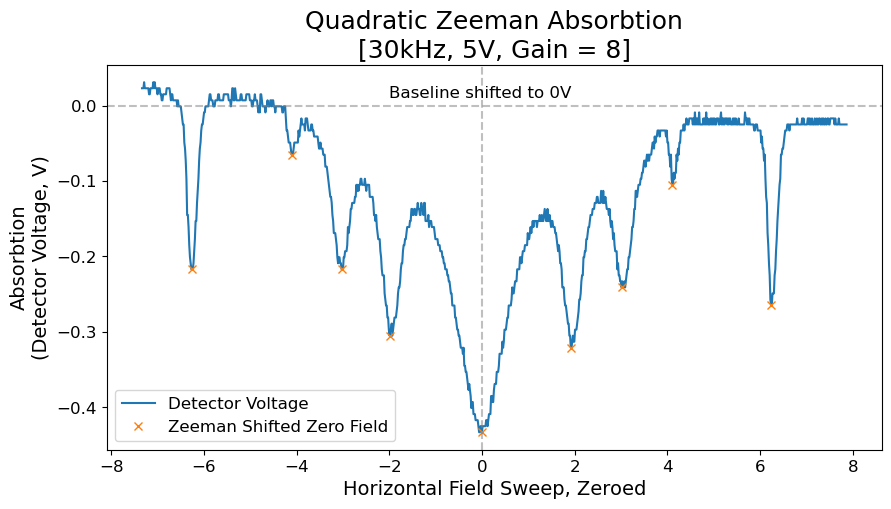

In [13]:
df_quad_results3 = []

# Extract the original sweep data for the column to be used as the new x-axis
original_x_values = df_quad[df_quad.columns[4]].values

# Generate new x-values with 1000 points spaced evenly between the min and max of the original x-values
new_x_values = np.linspace(original_x_values.min(), original_x_values.max(), 1000)

# Pull detector reading data, then negate to make minimum maximum (to work with find_peaks function)
data_zero = df_quad[df_quad.columns[5]].values
inverted_data_zero = -np.array(data_zero)

# Find peaks in the inverted data (thus, minimums since it is inverted;
# Adjust parameters as needed; Note: '_' is a necessary empty return value holder
peaks, _ = find_peaks(inverted_data_zero, distance = 20, prominence = 0.02)  # Adjust prominence and distance using graph above

#! - shift these to the right to rezero.  Hey its the xval at minimum!
zero_x_vals = [t - float(new_x_values[median(peaks)]) for t in new_x_values]

# Get baseline voltage from the average of the first and last 5 measurements
baseline = round((sum(data_zero[:5]) + sum(data_zero[-5:]))/10,3)

# Shift the entire graph down by baseline for cleaner calculation of voltage drop at detector
data_zero = data_zero - baseline

# Get list of minima values
minimas = data_zero[peaks]

# Plotting to check accuracy (can comment out after peaks confirmed)
plt.figure(figsize=(10, 5))
plt.plot(zero_x_vals, data_zero, label='Detector Voltage')

plt.plot(new_x_values[peaks]-float(new_x_values[median(peaks)]),minimas,"x", label=f'Zeeman Shifted Zero Field')


plt.xlabel('Horizontal Field Sweep, Zeroed')
plt.ylabel('Absorbtion\n(Detector Voltage, V)')
plt.title('Quadratic Zeeman Absorbtion\n[30kHz, 5V, Gain = 8]')
plt.legend()

# Adding in the baselines
# Horiz
plt.axhline(0, color = 'grey', linestyle = 'dashed', alpha = .5)
plt.text(-2,.01,f'Baseline shifted to 0V')
# Vertical
plt.axvline(0, color = 'grey', linestyle = 'dashed', alpha = .5)

# Add in Information


plt.show()


# for i in range(len(minimas)):
#         df_quad_results3.append(('Zero Field',
#                 new_x_values[zero_peak][i]))

In [14]:
# Ensure even numbers of Hz
quad_data = [df_quad_results[1]]*2 + df_quad_results[1:-6]

quad_data = [d for d in data if d[1] >= 0]

In [15]:
k_1q = []
k_2q = []
k_3q = []

counter = 0
for row in quad_data:
    if counter == 0:
        k_1q.append((row[1],row[0]))
    elif counter == 1:
        k_2q.append((row[1],row[0]))
    else:
        k_3q.append((row[1],row[0]))
        counter = 0
        continue
    counter += 1
    
dq = [k_2q] + [k_3q]

In [16]:
dq

[[(0.45245245245245336, 10),
  (1.726726726726728, 20),
  (2.563563563563564, 30),
  (3.429229229229229, 40),
  (3.9709709709709724, 50),
  (4.731731731731733, 60),
  (5.5023023023023026, 70),
  (6.1011011011011025, 80)],
 [(0.45245245245245336, 10),
  (2.468468468468469, 20),
  (3.6476476476476485, 30),
  (4.8556556556556565, 40),
  (5.720720720720722, 50),
  (6.823823823823826, 60),
  (7.974774774774776, 70),
  (8.915915915915917, 80)]]

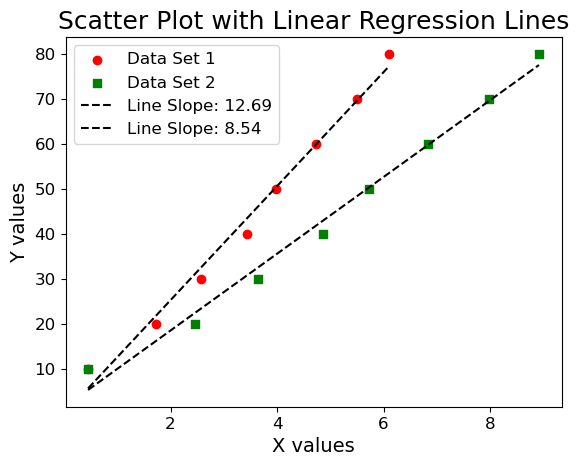

In [17]:
# Initialize plot
fig, ax = plt.subplots()

# Colors for different datasets
colors = ['red', 'green', 'blue']
markers = ['o', 's', 'D']

# To store regression lines data
regression_lines = []

# Plotting each set of data points and calculating regression lines
for index, sublist in enumerate(dq):
    x = np.array([point[0] for point in sublist]).reshape(-1, 1)
    y = np.array([point[1] for point in sublist])  # Y values

    # Scatter plot of points
    ax.scatter(x, y, color=colors[index], label=f'Data Set {index + 1}', marker=markers[index])

    # Linear regression
    model = LinearRegression().fit(x, y)
    line_x = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Generate x values for line
    line_y = model.predict(line_x)  # Predict y values for line

    # Store regression line data
    regression_lines.append((line_x, line_y, model.coef_[0]))

# Plot regression lines
for line_x, line_y, slope in regression_lines:
    ax.plot(line_x, line_y, 'k--', label=f'Line Slope: {slope:.2f}')

# Add title and labels
ax.set_title('Scatter Plot with Linear Regression Lines')
ax.set_xlabel('X values')
ax.set_ylabel('Y values')

# Show legend
ax.legend()

# Show plot
plt.show()